In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Retrieve metric metadata from SQLite db and metric data from .npz files

Now we are going to make some plots of the output of the previous notebook.

### **Important:**  
As in the last notebook, in the next cell you need to update the `your_username` variable with **Your Username** (between the single quotes).  After you have done that, in principle, you should be able to run the notebook all at once instead of cell by cell. 

In [50]:
#Please enter your SciServer username between the single quotes below!
your_username = 'somayeh91'

In [51]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

Import the sims_maf modules needed.

In [52]:
# import maf python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [53]:
# import convenience functions
from opsimUtils import *

### 1. Read result SQLite db and read in metric data
Each time you run MAF on an opsim simulation, MAF produces two types of files:
1. `*.db`: A SQLite database storing metadata and summary statistics for each metric run on the opsims.
2. `*.npz`: A file storing metric values (e.g., those used to generated plots and histograms) per metric and per opsim. The name of this file is also stored in the above `*.db` files.

If you followed the [Introduction](./Introduction.ipynb) notebook, metadata for metrics run on each opsim will be stored in separate files (using the convention 'runName_result.db', otherwise all in one 'resultDb_sqlite.db' by default). You can easily retrieve the metadata from those files using the provided conveience functions.

**Note:** You can either provide the path to the directory where all the resulting SQLite databases are stored or hard code the paths to each individual result database.

To read results stored in files, we need the paths to two directories:
1. `resultDbPath`: The path to the directory where the `runName_result.db` metadata databases are stored.
2. `metricDataPath`: The path to the directory where the actual metric data (`*.npz` files) are stored.

In [69]:
if your_username == '': # do NOT put your username here
    raise Exception('Please provide your username! See the top of the notebook.')

# user provided paths
resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/db_results_11_22_2020/'.format(your_username)
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/metric_data_11_22_2020/'.format(your_username)

In [70]:
# get a dictionary of resultDb from given directory
resultDbs = getResultsDbs(resultDbPath)

# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())

In [71]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts = {}

for runName in resultDbs:
    try:
        bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)
    except:
        pass

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


#### BundleDict Keys:
If you have gone through all the previous notebooks ([Introduction.ipynb](./00_Introduction.ipynb)) and [Multiple_Opsims.ipynb](./01_Multiple_Opsims.ipynb), you should be familiar with the term 'bundleDict' and 'metricBundle'. A metricBundle is a combination of metric (e.g., CoaddM5), slicer (e.g., healpixSlicer) and sql constraint (e.g., filter = 'g') and a bundleDict is a dictionary of multiple metricBundles. Each item in the `bundleDicts` shown in the cell above is one bundleDict. While reconstructing the bundleDict, we give each metricBundle a tuple key in the format of ('metricId', 'metricName'). metricId is unique while metricName is not, that is you can run same metric using differerent sql constraints. To make sure that we are comparing apples to apples, the `plotHist()` function and `plotSky()` function, which will be introducted below, require the tuple metricKey instead of just the metric name. 

In [72]:
# we see the available metric keys
list(bundleDicts[runNames[0]].keys())

[(1, 'StarCount '),
 (2, 'CampaignLength season'),
 (3, 'Number of revisits faster than 30.0 minutes'),
 (4, 'Uniformity observationStartMJD')]

The 2nd and the 3rd have the same metric name, but we can see the difference between the two by retrieving the full metadata using `get_metricMetadata()`. Note that the keys of `bundleDicts`, `resultDbs` are opSim run names. 

In [73]:
# print('{}: '.format(runNames[0])) # show the opsim run name where the metric metadata comes from
# get_metricMetadata(resultDbs[runNames[0]], metricName='CoaddM5')

In [74]:
camlen = bundleDicts[runName][2, 'CampaignLength season']

In [75]:
mask = camlen.metricValues.mask
np.median(camlen.metricValues.data[~mask])

10.0

In [76]:
mm = get_metricNames(resultDbs[runNames[0]])
mm

['CampaignLength season',
 'Number of revisits faster than 30.0 minutes',
 'StarCount ',
 'Uniformity observationStartMJD']

In [82]:
summary = getSummary(resultDbs, 'StarCount ', 'Sum',pandas=True)
# summary = summary.drop(10)
summary

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue,runName
0,1,StarCount,UserPointsSlicer,r,Sum,5.529594e+07,footprint_stuck_rollingv1.5_10yrs
1,1,StarCount,UserPointsSlicer,r,Sum,5.558440e+07,footprint_standard_goalsv1.5_10yrs
2,1,StarCount,UserPointsSlicer,r,Sum,1.805655e+07,footprint_big_sky_dustv1.5_10yrs
3,1,StarCount,UserPointsSlicer,r,Sum,5.832278e+07,footprint_bluer_footprintv1.5_10yrs
4,1,StarCount,UserPointsSlicer,r,Sum,5.411200e+07,footprint_big_wfdv1.5_10yrs
5,1,StarCount,UserPointsSlicer,r,Sum,5.458607e+07,bulges_cadence_bulge_wfd_v1.5_10yrs
6,5,StarCount,UserPointsSlicer,g,Sum,5.334681e+07,bulges_cadence_bulge_wfd_v1.5_10yrs
7,1,StarCount,UserPointsSlicer,r,Sum,4.862781e+07,footprint_no_gp_northv1.5_10yrs
8,1,StarCount,UserPointsSlicer,r,Sum,1.131623e+07,footprint_big_skyv1.5_10yrs
9,1,StarCount,UserPointsSlicer,r,Sum,5.464952e+07,footprint_newBv1.5_10yrs


### 2. Compare opSims using summary statistics

You can retrieve all summary statistics stored in the metadata using function `getSummary()`. This function will return a dictionary, each item is an array of summary statistics for the required metric. You can pass `pandas = True` to this function to get a pandas dataframe instead.

In [85]:
stats = ['Median', 'Mean', 'Count', 'Rms', 'Max', 'Min', 'Sum']
OPSIM_run = 'bulges_cadence_bulge_wfd_v1.5_10yrs'
metric_names = [mm[-1], mm[2], mm[0], mm[1]]

for s in stats:
    for m in metric_names:
    

        summary = getSummary(resultDbs,m, s,pandas=True)
        print(m, summary[['summaryName','summaryValue', 'metricMetadata']][summary.runName == OPSIM_run])

Uniformity observationStartMJD   summaryName  summaryValue metricMetadata
5      Median      0.117803              r
6      Median      0.163118              g
StarCount    summaryName  summaryValue metricMetadata
5      Median   9865.500804              r
6      Median   8973.721550              g
CampaignLength season   summaryName  summaryValue metricMetadata
5      Median          10.0              r
6      Median          10.0              g
Number of revisits faster than 30.0 minutes   summaryName  summaryValue metricMetadata
5      Median          10.0              r
6      Median           7.0              g
Uniformity observationStartMJD   summaryName  summaryValue metricMetadata
5        Mean      0.121433              r
6        Mean      0.166253              g
StarCount    summaryName  summaryValue metricMetadata
5        Mean  12738.873393              r
6        Mean  12449.663527              g
CampaignLength season   summaryName  summaryValue metricMetadata
5        Me

In [67]:
mm

['CampaignLength season',
 'Number of revisits faster than 30.0 minutes',
 'StarCount ',
 'Uniformity observationStartMJD']

Next, we use a simple function to generate a bar plot for comparing opsim using the summary statistics.

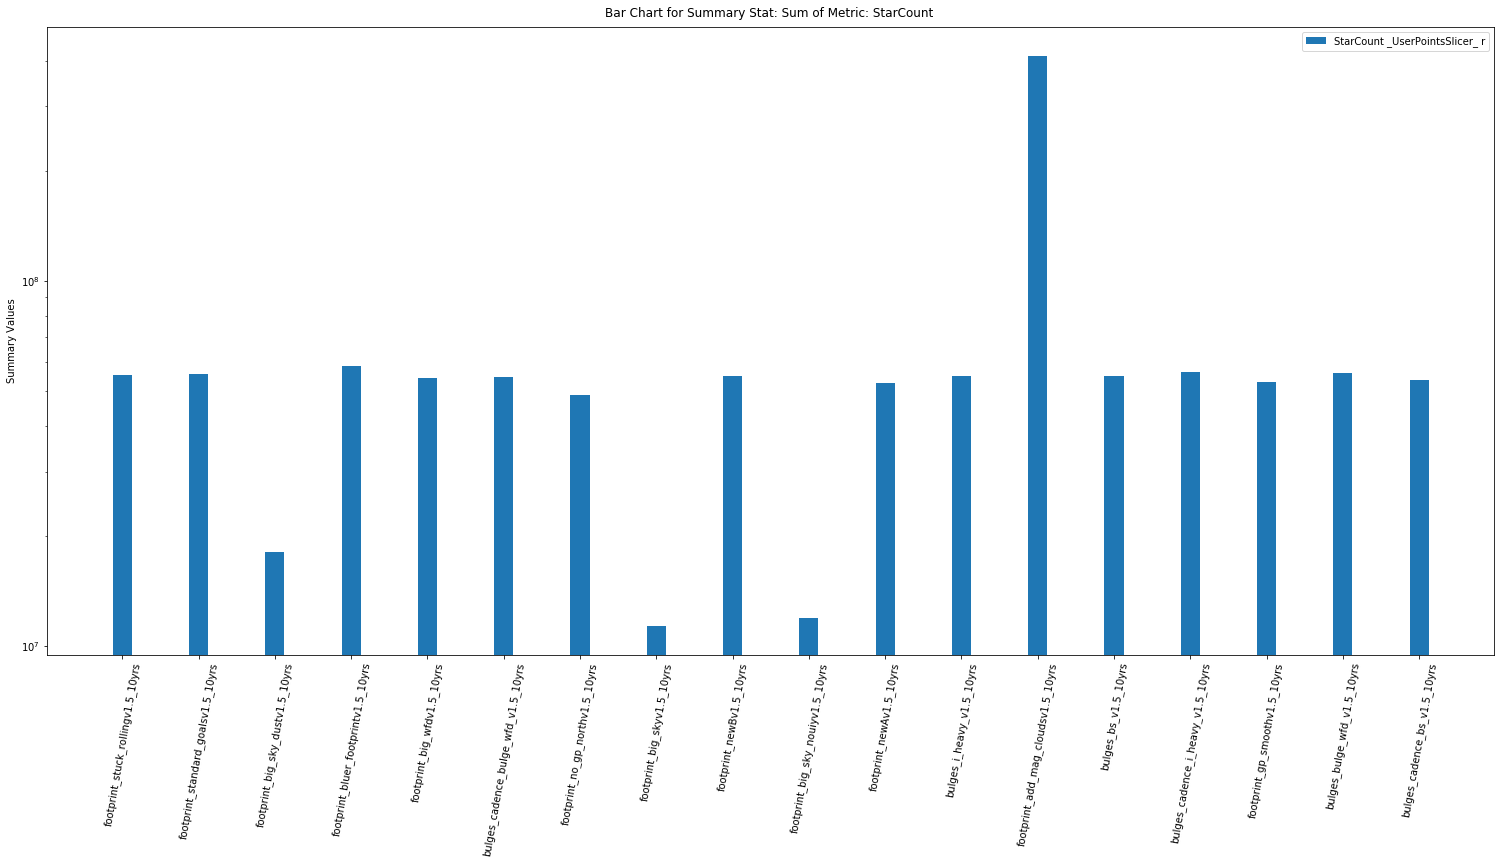

In [80]:
plotSummaryBar(resultDbs, mm[2], 'Sum', slicerName = 'HealpixSlicer')
fig = plt.gcf()
fig.set_size_inches(22.0,20.0)
plt.yscale('log')

Two convenience functions, `get_metricNames` and `get_summaryStatName`, are provided to check what metrics are available and and what summary statistics were run on a given metric.

In [19]:
get_metricNames(resultDbs[runNames[0]])

['CampaignLength season',
 'Number of revisits faster than 30.0 minutes',
 'StarCount ',
 'Uniformity observationStartMJD']

In [21]:
getSummaryStatNames(resultDbs[runNames[0]], mm[-1])

[{'metricId': 4,
  'StatNames': ['Count', 'Max', 'Mean', 'Median', 'Min', 'Rms', 'Sum']}]

### 3. Generate plots (hist/sky) using metric data
The following plotting functions, `plotHist()` and `plotSky()`, are simply an extension to the code provided in the [Introduction](./00_Introduction.ipynb) notebook. These functions are provided for quick visualization, you can easily make better looking plots by using the metric values loaded into metricbundles directly. For how to access the metric values, please look at the [Introduction](./00_Introduction.ipynb) notebook.  

Note that both functions require you to provide a **tuple** metric key

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 2303 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tri

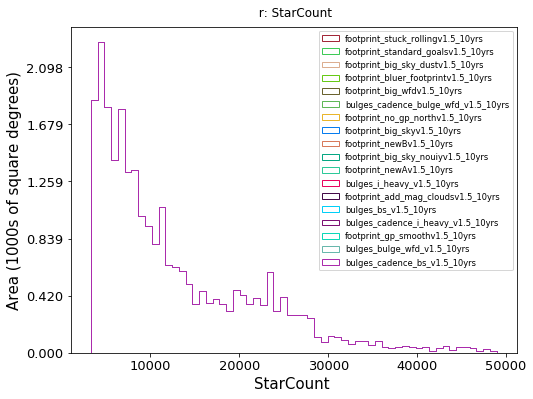

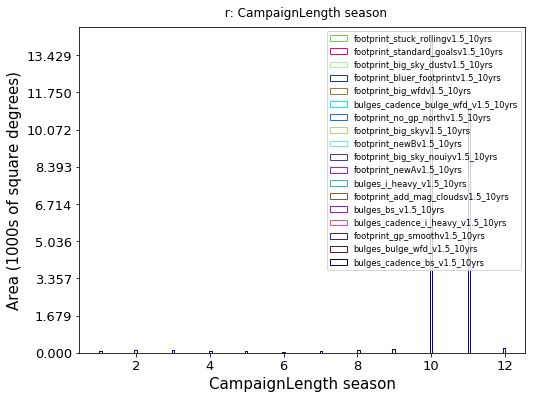

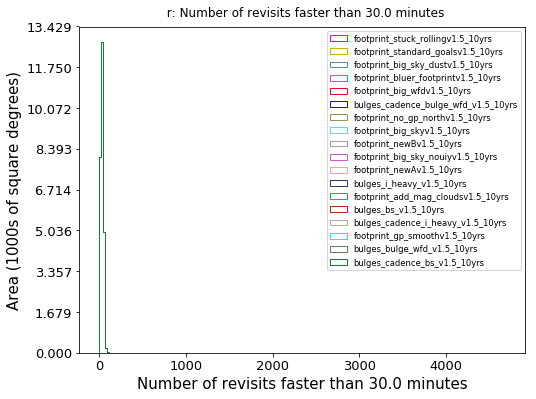

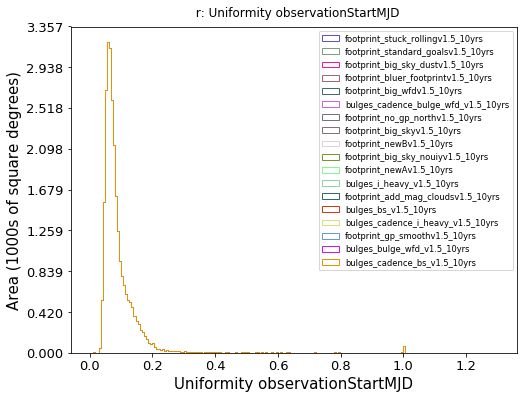

In [22]:
# plot hist for both metric of all opsims in one figure
plotHist(bundleDicts, (1, 'StarCount '))
plotHist(bundleDicts, (2, 'CampaignLength season'))
plotHist(bundleDicts, (3, 'Number of revisits faster than 30.0 minutes'))
plotHist(bundleDicts, (4, 'Uniformity observationStartMJD'))

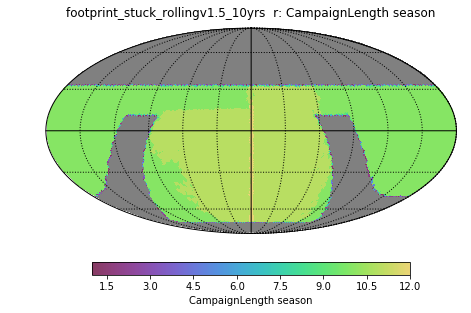

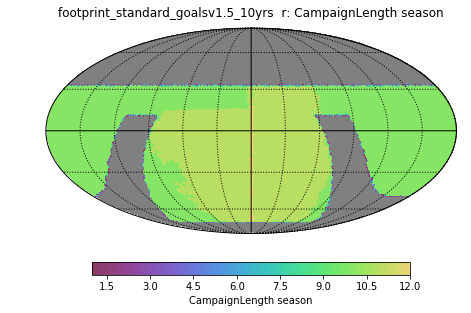

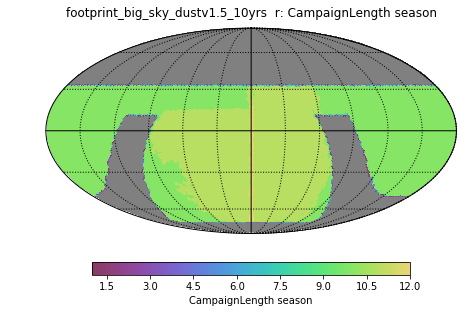

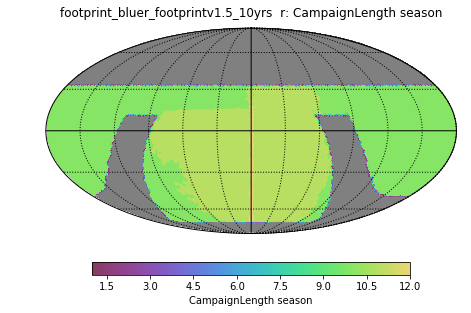

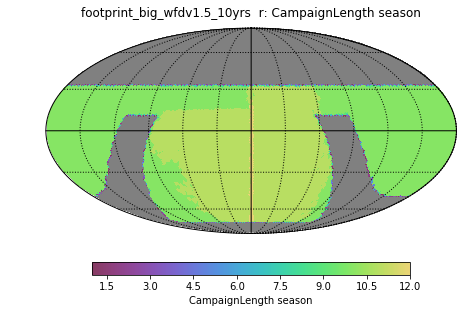

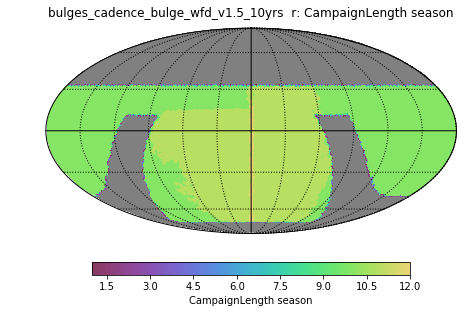

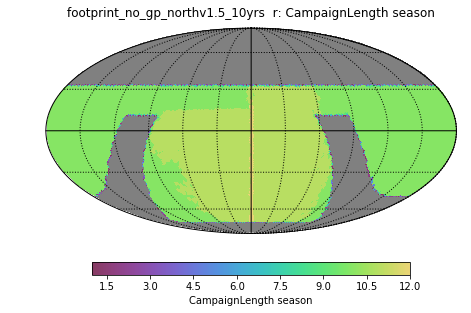

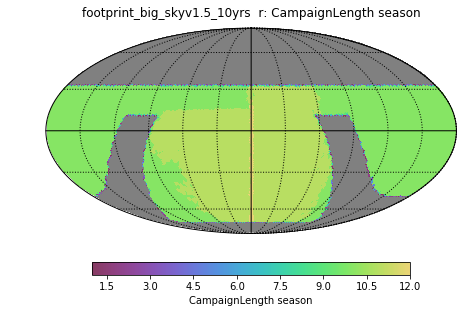

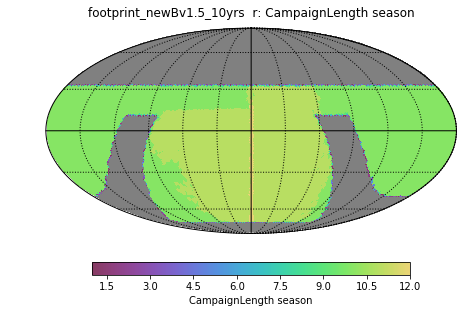

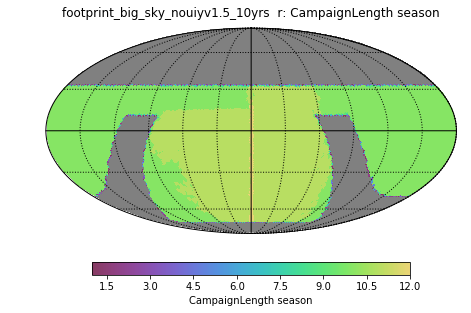

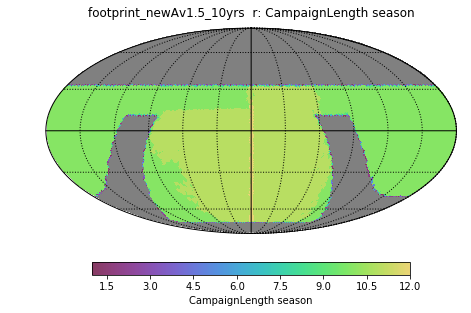

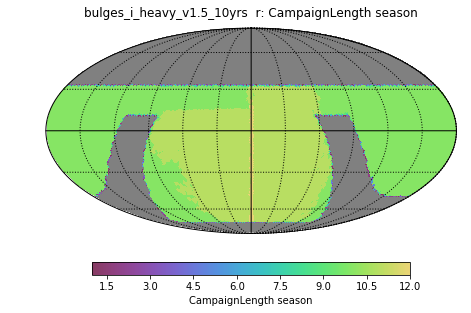

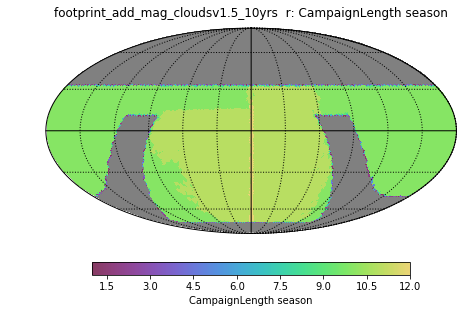

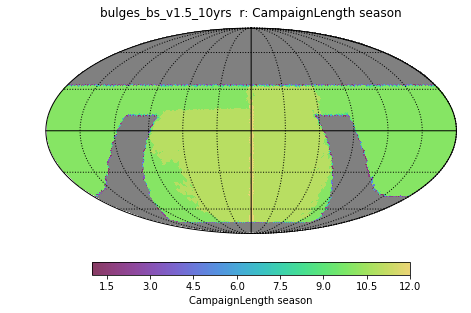

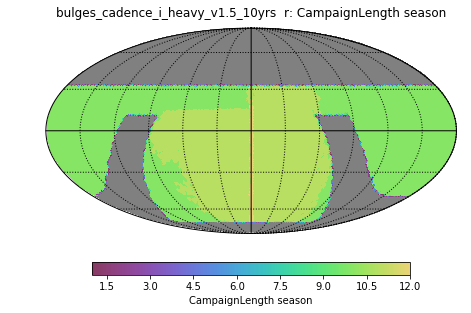

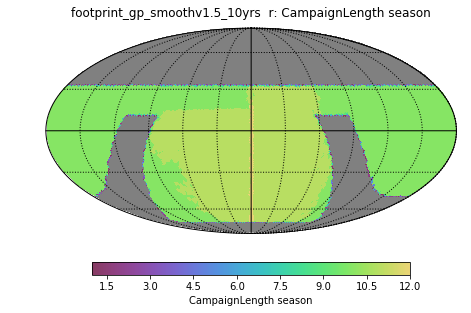

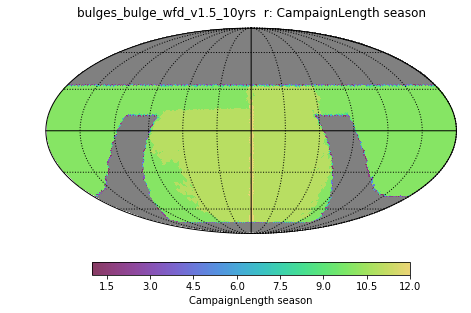

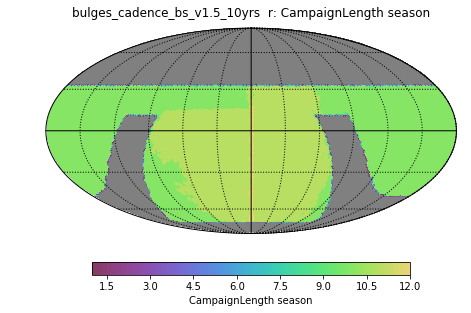

In [24]:
# Make sky plots
plotSky(bundleDicts, (2, 'CampaignLength season'))